In [531]:
import drawsvg as draw
import itertools
import numpy as np

In [532]:
THETA = 0.2
PHI = 0.2
WIDTH = 1000
HEIGHT = 400
BASE_COLOR = 'grey'
FONT_SIZE = 10
TEXT_SPACING = 10

layer_types = {
    '3 by 3 Convolution + ReLU': ('#005abe', 'C'),
    '2 by 2 Pooling': ('#be2000', 'C'),
    'Fully Connected + Softmax': ('#be9200', 'F'),
}


class Object3D:
    def __init__(self, points, edges, color):
        self.points = points
        self.edges = edges
        self.rotated_points = self.rotate_points(points)
        self.center = self.get_center(self.points)
        self.center2D = self.get_center(self.rotated_points)
        self.color = color
    
    def get_center(self, points):
        return np.mean(points, axis=0)
    
    def rotate_points(self, points):
        
        rotation_x = np.array([[1, 0, 0], [0, np.cos(THETA), -np.sin(THETA)], [0, np.sin(THETA), np.cos(THETA)]])
        rotation_y = np.array([[np.cos(PHI), 0, np.sin(PHI)], [0, 1, 0], [-np.sin(PHI), 0, np.cos(PHI)]])
        
        return np.dot(np.dot(points, rotation_x), rotation_y)
    
    def draw(self, d):
        
        for edge in self.edges:
            d.append(draw.Line(*self.rotated_points[edge[0]][0:2], *self.rotated_points[edge[1]][0:2], stroke=self.color))
        

class Cube(Object3D):
    def __init__(self, x, y, z, width, height, depth, color=BASE_COLOR):
        super().__init__([np.array([x, y, z]) + np.array([i * depth, j * height, k * width]) for i in [-0.5, 0.5] for j in [-0.5, 0.5] for k in [-0.5, 0.5]], [
            (0, 1), (1, 3), (3, 2), (2, 0),  # Bottom face
            (4, 5), (5, 7), (7, 6), (6, 4),  # Top face
            (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
        ], color)

class Pyramid(Object3D):
    def __init__(self, x, y, z, height, size, color=BASE_COLOR):
        super().__init__([np.array([x, y, z]), np.array([x+height, y +size/2, z+size/2]), np.array([x+height, y-size/2, z+size/2]), np.array([x+height, y-size/2, z-size/2]), np.array([x+height, y+size/2, z-size/2])]
                         , [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [2, 3], [3, 4], [4, 1]], color)

class Convolution():
    def __init__(self, image_size, kernel_size, depth, layer_type):
        self.image_size = image_size
        self.kernel_size = kernel_size
        self.depth = depth
        self.cube = None
        self.center = None
        self.center2D = None
        self.color = BASE_COLOR
        self.layer_type = layer_type
        if layer_type in layer_types:
            self.color = layer_types[layer_type][0]
    
    def draw(self, d, x):
        self.cube = Cube(x, 0, 0, self.image_size, self.image_size, self.depth, self.color)
        self.center = self.cube.center
        self.center2D = self.cube.center2D
        self.cube.draw(d)
        
        # get lowest point
        lowest_point = np.max(self.cube.rotated_points, axis=0)
        # Draw text
        text = [f'{self.image_size}x{self.image_size}x{self.depth}']
        if self.layer_type not in layer_types:
            text.insert(0,self.layer_type)
        d.append(draw.Text(text, FONT_SIZE, x, lowest_point[1]+TEXT_SPACING, fill='black', center=True))

class FullyConnected():
    def __init__(self, size, display_neuron_size, display_layer_height, layer_type):
        self.size = size
        self.display_neuron_size = display_neuron_size
        self.display_layer_height = display_layer_height
        self.center2D = None
        self.color = BASE_COLOR
        self.layer_type = layer_type
        if layer_type in layer_types:
            self.color = layer_types[layer_type][0]
    
    def draw(self, d, x):
        lines = [self.display_neuron_size/2 + x, self.display_layer_height/2, self.display_neuron_size/2 + x, -self.display_layer_height/2, -self.display_neuron_size/2 + x, -self.display_layer_height/2, -self.display_neuron_size/2 + x, self.display_layer_height/2]
        self.center2D = np.array([x, 0])
        d.append(draw.Lines(*lines, stroke=self.color, fill='none', close=True))
        
        for i in range(int(-self.display_layer_height/2+ self.display_neuron_size), int(self.display_layer_height/2), self.display_neuron_size):
            d.append(draw.Line(x-self.display_neuron_size/2, i, x+self.display_neuron_size/2, i, stroke=self.color))
        
        # Draw text
        text = [f'{self.size}']
        if self.layer_type not in layer_types:
            text.insert(0,self.layer_type)
        d.append(draw.Text(text, FONT_SIZE, x, self.display_layer_height/2 + TEXT_SPACING, fill='black', center=True))
        

def draw_network(d, network, spacing = 60, kernal_scale = 10, legend_spacing = 30, legend_pos = (180, -15 * (len(layer_types)-1)), marker_size =10,marker_spacing = 10, adjust_conv_marker =0, adjust_fc_marker = (0,0)):
    prev_layer = None
    for layer in network:
        if isinstance(layer, Convolution):
            x = (prev_layer.center[0] + prev_layer.depth/2 + spacing + layer.depth/2) if prev_layer else -WIDTH/2 + spacing
            layer.draw(d, x)
            
            if isinstance(prev_layer, Convolution):
                if layer.image_size <= prev_layer.image_size:
                    bounds = (layer.image_size - prev_layer.kernel_size*kernal_scale)/2
                    pos = np.array([x - layer.depth/2, np.random.randint(-bounds,bounds), np.random.randint(-bounds,bounds)])
                    p = Pyramid(*pos, -spacing, prev_layer.kernel_size* kernal_scale)
                    p.draw(d)
                else:
                    bounds = (prev_layer.image_size - prev_layer.kernel_size*kernal_scale)/2
                    pos = np.array([prev_layer.center[0] + prev_layer.depth/2, np.random.randint(-bounds,bounds), np.random.randint(-bounds,bounds)])
                    p = Pyramid(*pos, spacing, prev_layer.kernel_size* kernal_scale)
                    p.draw(d)
            
            prev_layer = layer
        
        if isinstance(layer, FullyConnected):
            x = prev_layer.center2D[0] + spacing + layer.display_neuron_size/2
            layer.draw(d, x)
            
            if isinstance(prev_layer, Convolution):
                point1 = (prev_layer.cube.rotated_points[5]+prev_layer.cube.rotated_points[4])/2
                point2 = (prev_layer.cube.rotated_points[6]+prev_layer.cube.rotated_points[7])/2
                d.append(draw.Line(point1[0], point1[1], x - layer.display_neuron_size/2, -layer.display_layer_height/2, stroke=BASE_COLOR))
                d.append(draw.Line(point2[0], point2[1], x - layer.display_neuron_size/2, layer.display_layer_height/2, stroke=BASE_COLOR))
            
            if isinstance(prev_layer, FullyConnected):
                d.append(draw.Line(prev_layer.center2D[0] + prev_layer.display_neuron_size/2, prev_layer.center2D[1] + prev_layer.display_layer_height/2, x - layer.display_neuron_size/2, layer.display_layer_height/2, stroke=BASE_COLOR))
                d.append(draw.Line(prev_layer.center2D[0] + prev_layer.display_neuron_size/2, prev_layer.center2D[1] - prev_layer.display_layer_height/2, x - layer.display_neuron_size/2, -layer.display_layer_height/2, stroke=BASE_COLOR))
            
            prev_layer = layer
    
    
    for i, (key, value) in enumerate(layer_types.items()):
        
        d.append(draw.Text(key, FONT_SIZE, legend_pos[0], i * legend_spacing + legend_pos[1]))
        if value[1] == 'C':
            Cube(legend_pos[0] - marker_spacing, i * legend_spacing + legend_pos[1] - marker_size/2 + adjust_conv_marker, 0, marker_size, marker_size, marker_size, value[0]).draw(d)
        elif value[1] == 'F':
            d.append(draw.Rectangle(legend_pos[0] - marker_size- marker_spacing+ adjust_fc_marker[0], i * legend_spacing + legend_pos[1] - marker_size + adjust_fc_marker[1], marker_size, marker_size, stroke=value[0], fill='none'))

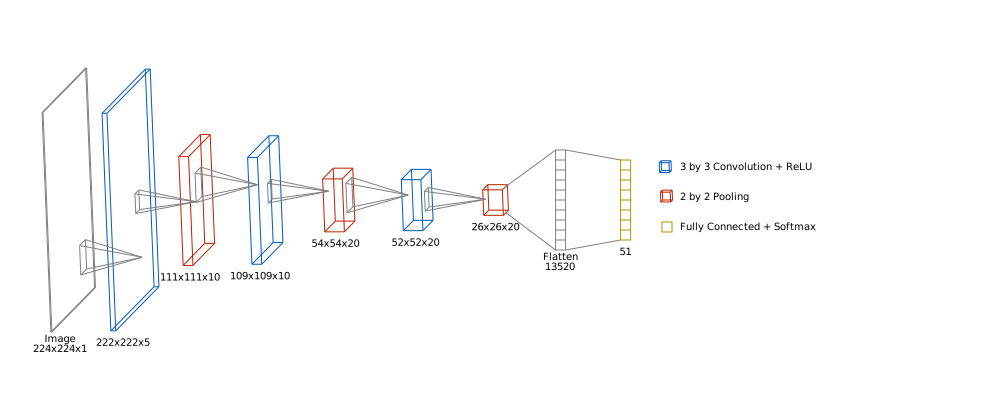

In [533]:

d = draw.Drawing(WIDTH, HEIGHT, origin='center')

network = [
    Convolution(224, 3, 1, 'Image'),
    Convolution(222, 2, 5, '3 by 3 Convolution + ReLU'),
    Convolution(111, 3, 10, '2 by 2 Pooling'),
    Convolution(109, 2, 10, '3 by 3 Convolution + ReLU'),
    Convolution(54, 3, 20, '2 by 2 Pooling'),
    Convolution(52, 2, 20, '3 by 3 Convolution + ReLU'),
    Convolution(26, 0, 20, '2 by 2 Pooling'),
    FullyConnected(26*26*20, 10, 100, 'Flatten'),
    FullyConnected(51, 10, 80, 'Fully Connected + Softmax'),
]

draw_network(d, network, adjust_fc_marker = (2,2), adjust_conv_marker=1)
d.save_svg('baseline.svg')
d 

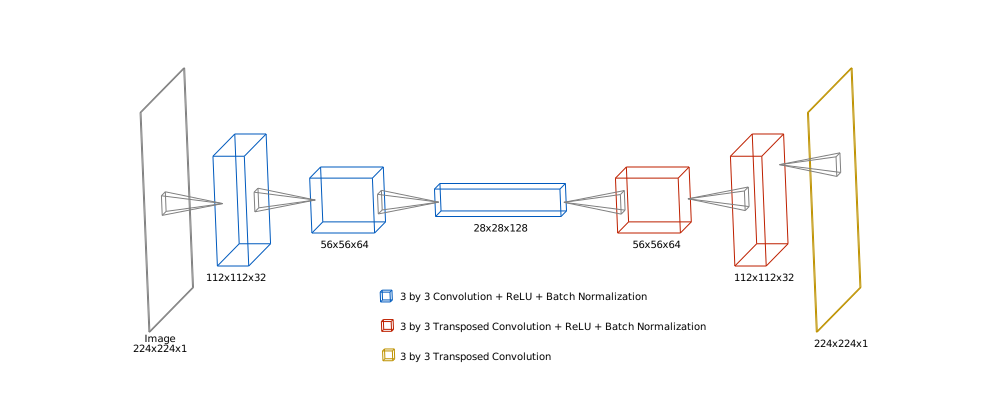

In [534]:
d = draw.Drawing(WIDTH, HEIGHT, origin='center')

CONV = '3 by 3 Convolution + ReLU + Batch Normalization'
CONV_TRANSPOSED = '3 by 3 Transposed Convolution + ReLU + Batch Normalization'
CONV_FINAL = '3 by 3 Transposed Convolution'
WIDTH = 800

layer_types = {
    CONV: ('#005abe', 'C'),
    CONV_TRANSPOSED: ('#be2000', 'C'),
    CONV_FINAL: ('#be9200', 'C'),
}

network = [
    Convolution(224, 2, 1, 'Image'),
    Convolution(112, 2, 32, CONV),
    Convolution(56, 2, 64, CONV),
    Convolution(28, 2, 128, CONV),
    Convolution(56, 2, 64, CONV_TRANSPOSED),
    Convolution(112, 2, 32, CONV_TRANSPOSED),
    Convolution(224, 2, 1, CONV_FINAL),
]

draw_network(d, network, legend_pos=(-100, 100), marker_spacing=20, adjust_conv_marker=3)
d.save_svg('baseline.svg')
d 